# PTBDB 逻辑回归 + 分类效果可视化
本 Notebook 使用固定路径导入数据，并展示分类表现（混淆矩阵、ROC、PR）。

## 1. 读取数据

In [5]:
import pandas as pd
import numpy as np

p_norm = "../data/ecg_category/ptbdb_normal.csv"
p_abn  = "../data/ecg_category/ptbdb_abnormal.csv"

print("✅ 使用固定路径:")
print("正常文件:", p_norm)
print("异常文件:", p_abn)

normal = pd.read_csv(p_norm, header=None)
abnormal = pd.read_csv(p_abn, header=None)

def find_label_col(df):
    for c in df.columns[::-1]:
        vals = df[c].dropna().unique()
        if set(vals).issubset((0, 1)):
            return c
    return None

ln, la = find_label_col(normal), find_label_col(abnormal)

if ln is not None:
    y_normal = normal[ln].astype(int).to_numpy()
    X_normal = normal.drop(columns=[ln]).to_numpy()
else:
    y_normal = np.zeros(len(normal), dtype=int)
    X_normal = normal.to_numpy()

if la is not None:
    y_abnormal = abnormal[la].astype(int).to_numpy()
    X_abnormal = abnormal.drop(columns=[la]).to_numpy()
else:
    y_abnormal = np.ones(len(abnormal), dtype=int)
    X_abnormal = abnormal.to_numpy()

m = min(X_normal.shape[1], X_abnormal.shape[1])
X = np.vstack([X_normal[:, :m], X_abnormal[:, :m]])
y = np.concatenate([y_normal, y_abnormal]).astype(int)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print("数据形状:", X.shape, " 标签形状:", y.shape)
print("类别分布:", dict(enumerate(np.bincount(y))))


✅ 使用固定路径:
正常文件: ../data/ecg_category/ptbdb_normal.csv
异常文件: ../data/ecg_category/ptbdb_abnormal.csv
数据形状: (14552, 187)  标签形状: (14552,)
类别分布: {0: 4046, 1: 10506}


## 2. 5 折交叉验证：标准化 + 逻辑回归

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs, bals = [], []
cm_sum = np.zeros((2,2), dtype=float)
probs, truths = [], []

for tr_idx, te_idx in skf.split(X, y):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    pipe = make_pipeline(StandardScaler(),
                         LogisticRegression(max_iter=2000, class_weight='balanced'))
    pipe.fit(X_tr, y_tr)

    y_prob = pipe.predict_proba(X_te)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    aucs.append(roc_auc_score(y_te, y_prob))
    bals.append(balanced_accuracy_score(y_te, y_pred))
    cm_sum += confusion_matrix(y_te, y_pred, labels=[0,1])
    probs.extend(y_prob)
    truths.extend(y_te)

print(f"平均 ROC-AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"平均 Balanced Acc: {np.mean(bals):.4f} ± {np.std(bals):.4f}")
print("平均混淆矩阵(近似):\n", np.round(cm_sum / skf.get_n_splits(), 1))


平均 ROC-AUC: 0.8797 ± 0.0056
平均 Balanced Acc: 0.8005 ± 0.0106
平均混淆矩阵(近似):
 [[ 673.   136.2]
 [ 484.6 1616.6]]


## 3. 分类效果可视化（混淆矩阵 + ROC + PR）

/var/folders/q3/gdq23gt17rzd5bt0r99nrktm0000gn/T/ipykernel_77397/2734295273.py:30: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q3/gdq23gt17rzd5bt0r99nrktm0000gn/T/ipykernel_77397/2734295273.py:30: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q3/gdq23gt17rzd5bt0r99nrktm0000gn/T/ipykernel_77397/2734295273.py:30: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q3/gdq23gt17rzd5bt0r99nrktm0000gn/T/ipykernel_77397/2734295273.py:30: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q3/gdq23gt17rzd5bt0r99nrktm0000gn/T/ipykernel_77397/2734295273.py:30: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q3/gdq2

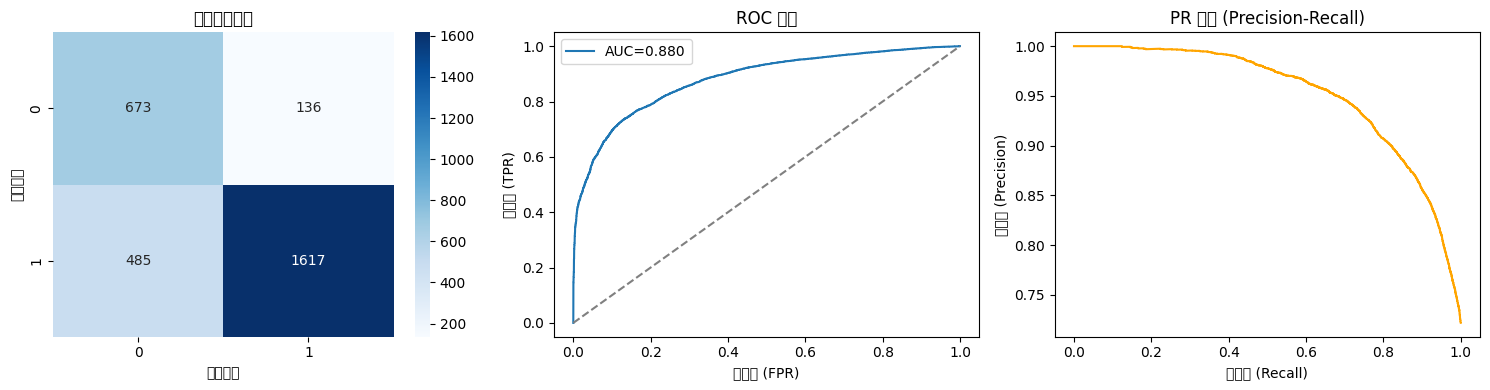

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fig, ax = plt.subplots(1, 3, figsize=(15,4))

# --- 混淆矩阵 ---
sns.heatmap(np.round(cm_sum / skf.get_n_splits()), annot=True, fmt=".0f", cmap="Blues", ax=ax[0])
ax[0].set_title("平均混淆矩阵")
ax[0].set_xlabel("预测标签")
ax[0].set_ylabel("真实标签")

# --- ROC 曲线 ---
fpr, tpr, _ = roc_curve(truths, probs)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
ax[1].plot([0,1],[0,1],'--',color='gray')
ax[1].set_title("ROC 曲线")
ax[1].set_xlabel("假阳率 (FPR)")
ax[1].set_ylabel("真阳率 (TPR)")
ax[1].legend()

# --- PR 曲线 ---
p, r, _ = precision_recall_curve(truths, probs)
ax[2].plot(r, p, color='orange')
ax[2].set_title("PR 曲线 (Precision-Recall)")
ax[2].set_xlabel("召回率 (Recall)")
ax[2].set_ylabel("精确率 (Precision)")

plt.tight_layout()
plt.show()
